In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import torch
from evaluate_classif import plot_tsne, test_rodie
from tqdm import tqdm
from preprocessing import *
from model import RODIE
from sklearn.manifold import TSNE
from train import  train_rodie
from  torch import nn
from torch.nn import RNNCell
from torch.nn.functional import one_hot
from torch.nn import functional as F
from torch.nn import MSELoss, HuberLoss,L1Loss,CrossEntropyLoss
from tqdm import tqdm
## Those settings speed up the training process on GPU
torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [2]:

## Download data
!wget https://snap.stanford.edu/data/act-mooc.tar.gz
!tar -xzf  act-mooc.tar.gz
!mkdir data

--2022-03-27 14:38:50--  https://snap.stanford.edu/data/act-mooc.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5378133 (5.1M) [application/x-gzip]
Saving to: ‘act-mooc.tar.gz.3’

act-mooc.tar.gz.3   100%[===================>]   5.13M  14.0MB/s    in 0.4s    

2022-03-27 14:38:51 (14.0 MB/s) - ‘act-mooc.tar.gz.3’ saved [5378133/5378133]

mkdir: cannot create directory ‘data’: File exists


In [3]:
features = pd.read_csv("act-mooc/mooc_action_features.tsv",sep="\t")
labels = pd.read_csv("act-mooc/mooc_action_labels.tsv",sep="\t")
users = pd.read_csv("act-mooc/mooc_actions.tsv",sep="\t")

#### Load & Preprocess Data

In [4]:
mooc_data = extract_data_mooc()

In [5]:
## Extract time diffs for both users and items interactions
delta_u  = delta(mooc_data.copy(),"user_id")
delta_i  = delta(mooc_data.copy(),"item_id")
## Standardize the columns
mooc_data['delta_u'] = delta_u/np.std(delta_u)
mooc_data['delta_i'] = delta_i/np.std(delta_i)

In [6]:
## Extract previous item interactions and past user state
PreviousItemInteraction_ = PreviousItemInteraction(mooc_data.copy()).astype(int)
next_state_user = PastUserState(mooc_data.copy()).astype(int)
interaction_column_name = "PreviousItemInteraction"
pastState_column_name =  "previous_state_label"
mooc_data[interaction_column_name] = PreviousItemInteraction_
mooc_data[pastState_column_name] = next_state_user
list_moins_un = list(mooc_data[mooc_data[pastState_column_name] == -1].index.values)
mooc_data.loc[list_moins_un,pastState_column_name] = 0

In [7]:
data = mooc_data.copy()
data = data[['user_id', 'item_id', 'timestamp', 'state_label','delta_u', 'delta_i', interaction_column_name, pastState_column_name,'f1', 'f2', 'f3','f4']].sort_values(['timestamp'])
data.head()

,user_id,item_id,timestamp,state_label,delta_u,delta_i,PreviousItemInteraction,previous_state_label,f1,f2,f3,f4
ACTIONID,,,,,,,,,,,,
0,0,0,0.0,0,0.000000,0.000000,-1,0,-0.319991,-0.435701,0.106784,-0.067309
1,0,1,6.0,0,0.000064,0.000000,0,0,-0.319991,-0.435701,0.106784,-0.067309
2,0,2,41.0,0,0.000372,0.000000,1,0,-0.319991,-0.435701,0.106784,-0.067309
3,0,1,49.0,0,0.000085,0.007652,2,0,-0.319991,-0.435701,0.106784,-0.067309
4,0,2,51.0,0,0.000021,0.001780,1,0,-0.319991,-0.435701,0.106784,-0.067309


### T-batches

#### Train / Test SPLIT

In [8]:
t_batches = t_batch_update(data)

T-Batch start...
Number of interaction = 411749
Number of batch = 63461
T-Batch ends !


In [9]:
t_batch_train, valid_test, train_interactions, test_interactions = t_batch_train_test(data,t_batches,39917)

Train : Number of interactions in 39917 batches is equal to 247051
Test : Number of interactions is equal to 164698


##### Initialize Device

In [10]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = "cpu"
print('Using device:', device)

Using device: cuda


##### Initialize the model

In [11]:
# Its important to add this to the loss, because the dataset is unbalanced
dropout_ratio_train = len(train_interactions)/(1.0+ np.sum(data.loc[train_interactions,'state_label']))
weight_ratio_train = torch.Tensor([1.0,dropout_ratio_train]).to(device)
print("Number of dropout in the train data is {}".format(np.sum(data.loc[train_interactions,'state_label'])))

int_test = valid_test.index.values.tolist()
dropout_ratio_test = len(int_test)/(1.0+ np.sum(data.loc[int_test,'state_label']))
weight_ratio_test = torch.Tensor([1.0,dropout_ratio_test]).to(device)

print("Number of dropout in the test data is {}".format(np.sum(data.loc[test_interactions,'state_label'])))


Number of dropout in the train data is 2588
Number of dropout in the test data is 1478


In [12]:
valid_data,test_data = valid_test[:int(len(valid_test)/2)].copy(), valid_test[int(len(valid_test)/2):].copy()

In [22]:
def train_rodie(t_batches,data,valid_data,train_interactions,weight_ratio_train,weight_ratio_valid,model,learning_rate,n_epochs,lambda_u,lambda_i,device,):
  losses_train = []
  losses_valid = []

  initial_user_embedding = torch.nn.Parameter(F.normalize(torch.rand(128).to(device), dim=0) )# the initial user and item embeddings are learned during training as well
  initial_item_embedding = torch.nn.Parameter(F.normalize(torch.rand(128).to(device), dim=0))
  model.initial_user_embedding = initial_user_embedding
  model.initial_item_embedding =  initial_item_embedding
  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)
  for name, param in model.named_parameters():
    if param.requires_grad:
      print(name)

      
  print("Training...")
  for e in range(n_epochs):
    optimizer.zero_grad()
    U = initial_user_embedding.repeat(7047, 1)# initialize all users to the same embedding 
    I = initial_item_embedding.repeat(98, 1) # initialize all items to the same embedding
    train_err = 0
    #print("END EPOCH : Users Embeddings after update EPOCH 2 \n")
    #print(I)
    for (_,rows),t in zip(t_batches.items(),tqdm(range(len(t_batches)), position=0, leave=True)):
      optimizer.zero_grad()
      users_idx,items_idx = extractItemUserId(data,rows)
      state_label,delta_u,delta_i,f = extractFeatures(data,rows)
      past_item = extractPastItem(data,rows)
      u_static, i_static = model.static_users_embedding[users_idx], model.static_items_embedding[items_idx]


      user_embedding, item_embedding = U[users_idx], I[items_idx]
      past_item_static_embedding, past_item_dynamic_embedding = model.static_items_embedding[[int(x) for x in past_item]], I[[int(x) for x in past_item]]

      u_static = u_static.to(device)
      i_static = i_static.to(device)
      f = f.to(device)
      delta_u = delta_u.to(device)
      delta_i = delta_i.to(device)
      state_label = state_label.type(torch.LongTensor).to(device)
      past_item_dynamic_embedding = past_item_dynamic_embedding.to(device)
      past_item_static_embedding = past_item_static_embedding.to(device)
      
      # The forward pass of the model : extract dynamic embeddings (user+item ), and predicted user state and predicted item embedding
      future_user_embedding,future_item_embedding,U_pred_state,j_tilde,j_true = model(item_embedding,
                user_embedding,
                u_static,
                i_static,
                f,
                delta_u,
                delta_i,
                past_item_dynamic_embedding,
                past_item_static_embedding)
      # Add the new embedding to the placeholder U and I

      # Return loss value between the predicted embedding "j_tilde" and the real past item embedding j_true
      
      loss = MSELoss()(j_tilde,j_true)#.detach()
      loss += regularizer(user_embedding.detach(),future_user_embedding,lambda_u,
                            item_embedding.detach(),future_item_embedding,lambda_i
                            )
      
      loss += CrossEntropyLoss(weight_ratio_train)(U_pred_state,state_label)
      loss.backward()
      train_err += loss.item()
      optimizer.step()

      U.detach()[users_idx] = future_user_embedding.detach()
      I.detach()[items_idx] = future_item_embedding.detach()
      optimizer.zero_grad()
    y, pred,_,_,auc,valid_err = test_rodie(valid_data,weight_ratio_valid,U.detach().clone(), I.detach().clone(), data, model, device)
    losses_train.append(train_err/len(train_interactions))
    losses_valid.append(valid_err/(len(data)-len(train_interactions)))

    print("validation interactions {}".format(len(data)-len(train_interactions)))
    print("Epoch {} Train Loss {}".format(e,train_err))
    print("Epoch {} Validation Loss {} , AUC Score {}".format(e,valid_err,auc))

    if e%1 ==0:
      torch.save(model.state_dict(), "model_ep{}".format(e))
    print("Saving the model ...")

    if e == n_epochs - 1:
      torch.save(model.state_dict(), "modelFinal_ep{}".format(e))
  return model,U,I,losses_train,losses_valid



##### Train Loop

In [ ]:
embedding_dim = 128
data_torch = torch.from_numpy(data.values.astype(np.float32))
model = RODIE(embedding_dim,data_torch,device=device,activation_rnn="tanh").to(device)

n_epochs = 50
lambda_u = 1
lambda_i = 1
learning_rate=1e-4 #1e-4

model_,U_train,I_train,loss_list,valid_loss = train_rodie(t_batch_train,
          data_torch,
          valid_data,
          train_interactions,
          weight_ratio_train,
          weight_ratio_test,
          model,
          learning_rate,
          n_epochs,
          lambda_u,
          lambda_i,
          device
          )

Number of users of 7047 
 Number of items 97 

Dataset size [411749, 12]
Initialisation of static embedding... Done !
Static Embedding shape : Users [7047, 7047], 	 Items [98, 98]
Initialisation of rnn's with tanh activation function... Done !
Initialisation of MLP... Done !
initial_user_embedding
initial_item_embedding
item_rnn.weight_ih
item_rnn.weight_hh
item_rnn.bias_ih
item_rnn.bias_hh
user_rnn.weight_ih
user_rnn.weight_hh
user_rnn.bias_ih
user_rnn.bias_hh
projection_layer.weight
projection_layer.bias
predictItem_layer.0.weight
predictItem_layer.0.bias
predictStateUser_MLP.0.weight
predictStateUser_MLP.0.bias
predictStateUser_MLP.2.weight
predictStateUser_MLP.2.bias
Training...


100%|█████████▉| 39916/39917 [04:09<00:00, 160.21it/s]


Testing...


 99%|█████████▉| 160/161 [00:02<00:00, 62.08it/s]


validation interactions 164698
Epoch 0 Train Loss 8534.233747012913
Epoch 0 Validation Loss 224.35377344116569 , AUC Score 0.6366004676097998
Saving the model ...


100%|█████████▉| 39916/39917 [04:08<00:00, 160.72it/s]


Testing...


 99%|█████████▉| 160/161 [00:02<00:00, 61.48it/s]


validation interactions 164698
Epoch 1 Train Loss 8334.041502726264
Epoch 1 Validation Loss 235.85523607954383 , AUC Score 0.6044288648157671
Saving the model ...


100%|█████████▉| 39916/39917 [04:07<00:00, 161.42it/s]


Testing...


 99%|█████████▉| 160/161 [00:02<00:00, 62.70it/s]


validation interactions 164698
Epoch 2 Train Loss 8295.414879070595
Epoch 2 Validation Loss 235.93285384774208 , AUC Score 0.6231695612058041
Saving the model ...


100%|█████████▉| 39916/39917 [04:08<00:00, 160.71it/s]


Testing...


 99%|█████████▉| 160/161 [00:02<00:00, 60.14it/s]


validation interactions 164698
Epoch 3 Train Loss 8278.178965064697
Epoch 3 Validation Loss 233.00385462865233 , AUC Score 0.6283320866786927
Saving the model ...


100%|█████████▉| 39916/39917 [04:07<00:00, 161.30it/s]


Testing...


 99%|█████████▉| 160/161 [00:02<00:00, 61.47it/s]


validation interactions 164698
Epoch 4 Train Loss 8259.588454310782
Epoch 4 Validation Loss 231.98348312824965 , AUC Score 0.6257049317156631
Saving the model ...


100%|█████████▉| 39916/39917 [04:07<00:00, 161.18it/s]


Testing...


 99%|█████████▉| 160/161 [00:02<00:00, 60.86it/s]


validation interactions 164698
Epoch 5 Train Loss 8249.596195854247
Epoch 5 Validation Loss 229.55085149034858 , AUC Score 0.629382858279523
Saving the model ...


100%|█████████▉| 39916/39917 [04:06<00:00, 161.96it/s]


Testing...


 99%|█████████▉| 160/161 [00:02<00:00, 62.00it/s]


validation interactions 164698
Epoch 6 Train Loss 8247.621396257542
Epoch 6 Validation Loss 229.7724993750453 , AUC Score 0.6295730465126178
Saving the model ...


100%|█████████▉| 39916/39917 [04:06<00:00, 162.17it/s]


Testing...


 99%|█████████▉| 160/161 [00:02<00:00, 63.06it/s]


validation interactions 164698
Epoch 7 Train Loss 8249.735039762221
Epoch 7 Validation Loss 234.7845977321267 , AUC Score 0.5989695329846103
Saving the model ...


100%|█████████▉| 39916/39917 [04:06<00:00, 161.99it/s]


Testing...


 99%|█████████▉| 160/161 [00:02<00:00, 62.11it/s]


validation interactions 164698
Epoch 8 Train Loss 8281.008499712218
Epoch 8 Validation Loss 232.38211842626333 , AUC Score 0.6121893564132272
Saving the model ...


100%|█████████▉| 39916/39917 [04:06<00:00, 161.93it/s]


Testing...


 99%|█████████▉| 160/161 [00:02<00:00, 62.33it/s]


validation interactions 164698
Epoch 9 Train Loss 8113.956701835152
Epoch 9 Validation Loss 230.49575175344944 , AUC Score 0.6544520386622559
Saving the model ...


100%|█████████▉| 39916/39917 [04:05<00:00, 162.42it/s]


Testing...


 99%|█████████▉| 160/161 [00:02<00:00, 61.67it/s]


validation interactions 164698
Epoch 10 Train Loss 8035.896575472783
Epoch 10 Validation Loss 225.13467944785953 , AUC Score 0.6577340373296002
Saving the model ...


100%|█████████▉| 39916/39917 [04:06<00:00, 161.71it/s]


Testing...


 99%|█████████▉| 160/161 [00:02<00:00, 62.62it/s]


validation interactions 164698
Epoch 11 Train Loss 7983.482999698259
Epoch 11 Validation Loss 234.24212329089642 , AUC Score 0.6374161157620473
Saving the model ...


100%|█████████▉| 39916/39917 [04:06<00:00, 161.96it/s]


Testing...


 99%|█████████▉| 160/161 [00:02<00:00, 60.46it/s]


validation interactions 164698
Epoch 12 Train Loss 7965.542203927878
Epoch 12 Validation Loss 235.72847294807434 , AUC Score 0.6354436450014832
Saving the model ...


 13%|█▎        | 5024/39917 [00:30<03:34, 162.85it/s]

In [20]:
datatsne = TSNE(2).fit_transform(U.detach().cpu().numpy())

NameError: ignored

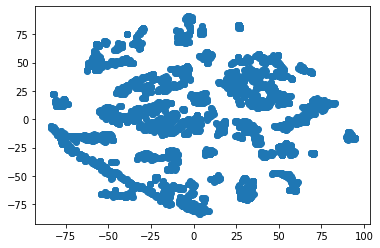

In [ ]:
plt.scatter(datatsne[:,0],datatsne[:,1])

In [ ]:
datatsne = TSNE(2).fit_transform(U.detach().cpu().numpy())

## TSNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


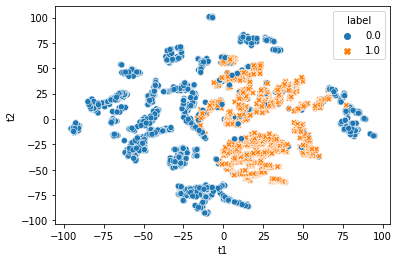

In [ ]:
tsne_embedding_users = plot_tsne(data,U,train_interactions,"user_id")


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


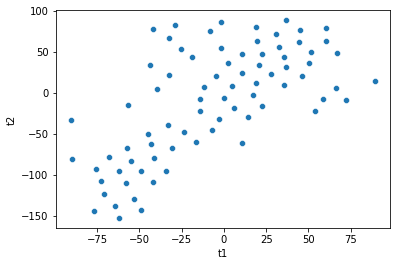

In [ ]:
tsne_embedding_items = plot_tsne(data,I,train_interactions,"item_id")

# Testing

In [ ]:
#model = RODIE(32,data_torch,device=device,activation_rnn="tanh").to(device)
#model_weight = torch.load("/content/model_ep0")
#model.load_state_dict(model_weight)

_, _,U_final,I_final,_,_ = test_rodie(valid_data,weight_ratio_test, U, I, data_torch, model_ ,device)
y, pred,U_test,I_test,auc,test_loss = test_rodie(test_data,weight_ratio_test, U_final, I_final, data_torch, model_ ,device)


Testing...


 99%|█████████▉| 160/161 [00:07<00:00, 20.07it/s]


Testing...


 99%|█████████▉| 160/161 [00:07<00:00, 21.14it/s]


In [ ]:
auc